In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from numpy.core.numeric import full
import pickle
import time
import random 
import pprint
import warnings
from collections import Counter
from scipy.spatial import distance
from operator import itemgetter


from copy import deepcopy

from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster

import skimage
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from skimage.color import gray2rgb, rgb2gray, label2rgb

from scipy.ndimage import convolve
from scipy.stats import zscore


# For keras dependencise
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Activation, Lambda, Reshape, Flatten
from keras.layers import BatchNormalization
from keras import losses
from keras import backend as K
from keras.losses import mse
from keras.optimizers import Adam


# For LRP Visuals
# from deepexplain.tensorflow import DeepExplain
from keras.models import Model

# LIME
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries, slic
from scipy import ndimage

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster

from PIL import Image


Using TensorFlow backend.


In [2]:
model = load_model("NN4.h5")

# Load data
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

# Load the feature activations
X_train_act = np.load("X_train_act.npy")
X_test_act = np.load("X_test_act.npy")

# Load DeepLIFT contributions
X_train_cont = np.load("new_X_train_deeplift.npy")
X_test_cont = np.load("new_X_test_deeplift.npy")

# X_test_cont shape
X_test_cont.shape

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2024-01-09 10:37:44.680889: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-01-09 10:37:44.713796: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb73af5ff10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-01-09 10:37:44.713822: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


(10000, 128)

In [3]:
if False:
    from sklearn.utils import resample
    print("Work with few data")
    X_train, y_train = resample(X_train, y_train, replace=False, n_samples=1000, random_state=0, stratify=y_train)   

In [3]:
from lime_utils import get_top_features

top_five_features_file = "top_1000_features_lime_fixed.pkl"


if not os.path.exists(top_five_features_file):
    # print("Compute", top_five_features_file)
    class_top_features = get_top_features(X_train, y_train, model, num_features=1000, max_per_image=10)
    # Save the dictionary to a file
    with open(top_five_features_file, "wb") as f:
        pickle.dump(class_top_features, f)

else:
    # print("Load", top_five_features_file)
    with open(top_five_features_file, 'rb') as f:
        class_top_features = pickle.load(f)


In [4]:
from lime_utils import aggregate_superpixels

aggregated_result_file = "aggregated_result.pkl"

if not os.path.exists(aggregated_result_file):
    aggregated_superpixels = aggregate_superpixels(class_top_features)

    with open(aggregated_result_file, "wb") as f:
        pickle.dump(aggregated_superpixels, f)
else:
    print("Load", aggregated_result_file)
    with open(aggregated_result_file, "rb") as f:
        aggregated_superpixels = pickle.load(f)


Load aggregated_result.pkl


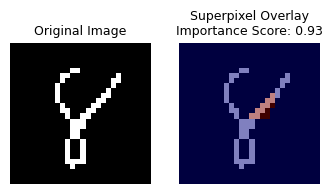

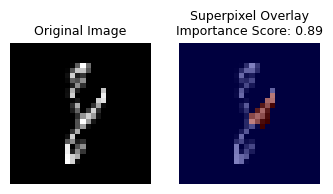

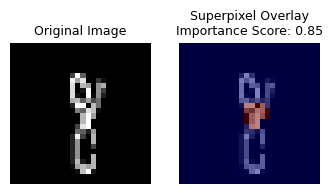

In [18]:
def plot_superpixel_overlay(original_image, superpixel_mask, importance_score):
    """
    Plot an original image with its superpixel overlay and the corresponding importance score.
    """
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image', fontsize=9)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(original_image, cmap='gray')
    plt.imshow(superpixel_mask, cmap='jet', alpha=0.5)  # Overlay the superpixel mask with transparency
    plt.title(f'Superpixel Overlay\nImportance Score: {importance_score:.2f}', fontsize=9)
    plt.axis('off')
    plt.show()

# Visualise top superpixels for a sample class
sample_class = list(class_top_features.keys())[4]  # get the first class
sample_features = class_top_features[sample_class][:3]  # get the top 3 features for the class

for mask, image, score, imgid in sample_features:
    original_img = X_train[imgid].reshape(28, 28)  # reshape if necessary, assuming images are 28x28
    plot_superpixel_overlay(original_img, mask, score)

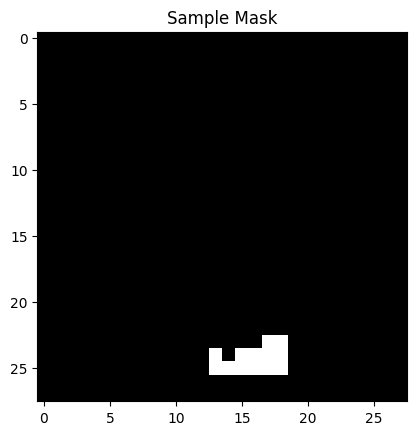

Sample Importance Score: 0.8770106925321026


In [5]:
sample_class = list(class_top_features.keys())[0]  # get the first class
sample_mask, sample_image, sample_score, _ = class_top_features[sample_class][0]  # get the first feature of the first class

# Visualize the sample mask
plt.imshow(sample_mask, cmap='gray')
plt.title('Sample Mask')
plt.show()

# Print the sample importance score
print("Sample Importance Score:", sample_score)


In [37]:
# Overall statistics between class_top_features and aggregated_superpixels
print("Number of classes:", len(class_top_features))
print("Number of classes of aggregated superpixels:", len(aggregated_superpixels))

def iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return np.sum(intersection) / np.sum(union)

# Initialize empty list to collect IoU scores
iou_scores = []

# Iterate over each class ID
for class_id in class_top_features.keys():
    
    # Access the data for this class ID from both dictionaries
    class_data_original = class_top_features[class_id]
    class_data_aggregated = aggregated_superpixels[class_id]
    
    # Iterate over each image/mask tuple in the original data
    for original_mask, _, _, imgid in class_data_original:
        
        # Find the corresponding aggregated mask for this image ID
        for aggregated_mask, _, _, aggregated_imgid in class_data_aggregated:
            if imgid == aggregated_imgid:
                
                # Compute the IoU for these two masks
                iou_score = iou(original_mask, aggregated_mask)
                
                # Append to list of IoU scores
                iou_scores.append(iou_score)

# Calculate the average IoU score
if len(iou_scores) > 0:
    print("Average IOU score between class_top_features and aggregated_superpixels:", np.mean(iou_scores))
else:
    print("No matching image IDs found for IoU calculation.")


Number of classes: 10
Number of classes of aggregated superpixels: 10
Average IOU score between class_top_features and aggregated_superpixels: 0.9069943289224953


In [38]:
# class-wise IoU scores
iou_scores = []

# Iterate over each class ID
for class_id in class_top_features.keys():
        
        # Access the data for this class ID from both dictionaries
        class_data_original = class_top_features[class_id]
        class_data_aggregated = aggregated_superpixels[class_id]
        
        # Iterate over each image/mask tuple in the original data
        for original_mask, _, _, imgid in class_data_original:
            
            # Find the corresponding aggregated mask for this image ID
            for aggregated_mask, _, _, aggregated_imgid in class_data_aggregated:
                if imgid == aggregated_imgid:
                    
                    # Compute the IoU for these two masks
                    iou_score = iou(original_mask, aggregated_mask)
                    
                    # Append to list of IoU scores
                    iou_scores.append(iou_score)
        
        # Calculate the average IoU score
        if len(iou_scores) > 0:
            print("Average IOU score for class", class_id, ":", np.mean(iou_scores))
        else:
            print("No matching image IDs found for IoU calculation for class", class_id)

            

Average IOU score for class 0 : 1.0
Average IOU score for class 1 : 0.8895140664961637
Average IOU score for class 2 : 0.8062015503875969
Average IOU score for class 3 : 0.8504715896020244
Average IOU score for class 4 : 0.8746721618583739
Average IOU score for class 5 : 0.8917598865605798
Average IOU score for class 6 : 0.9059352028314729
Average IOU score for class 7 : 0.9171264092108419
Average IOU score for class 8 : 0.920755119453925
Average IOU score for class 9 : 0.9069943289224953


Composite images. Average mask across all images in the classes before and after aggregating.

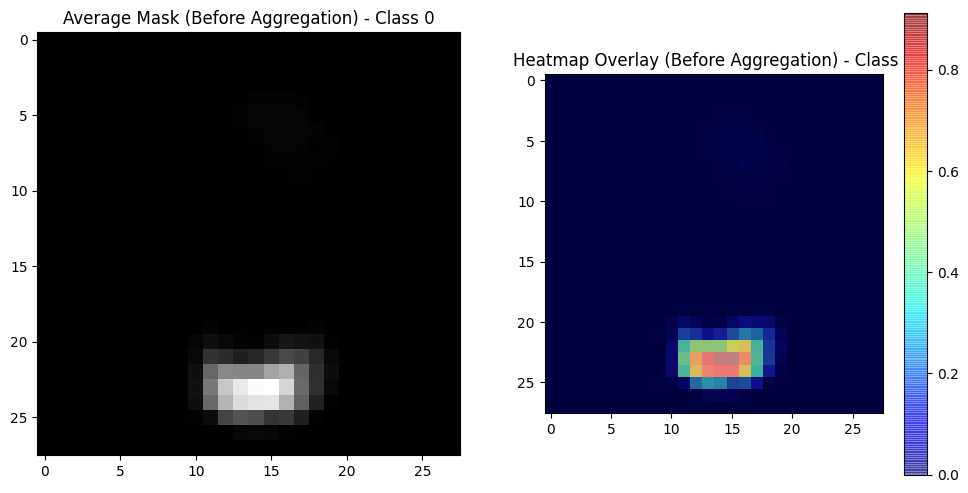

In [39]:
# Dictionary to store average masks for each class (before aggregation)
avg_masks_before = {}

for class_id, class_features in class_top_features.items():
    all_masks = np.array([mask for mask, _, _, _ in class_features])
    avg_mask = np.mean(all_masks, axis=0)
    avg_masks_before[class_id] = avg_mask

# Dictionary to store average masks for each class (after aggregation)
avg_masks_after = {}

for class_id, class_features in aggregated_superpixels.items():
    all_masks = np.array([mask for mask, _, _, _ in class_features])
    avg_mask = np.mean(all_masks, axis=0)
    avg_masks_after[class_id] = avg_mask


plt.figure(figsize=(12, 6))

# Original average mask for class 0 as an example
plt.subplot(1, 2, 1)
plt.imshow(avg_masks_before[0], cmap='gray')
plt.title('Average Mask (Before Aggregation) - Class 0')

# Heatmap overlay
plt.subplot(1, 2, 2)
plt.imshow(avg_masks_before[0], cmap='gray')
plt.imshow(avg_masks_before[0], cmap='jet', alpha=0.5)  # Overlay
plt.title('Heatmap Overlay (Before Aggregation) - Class 0')
plt.colorbar()

plt.show()


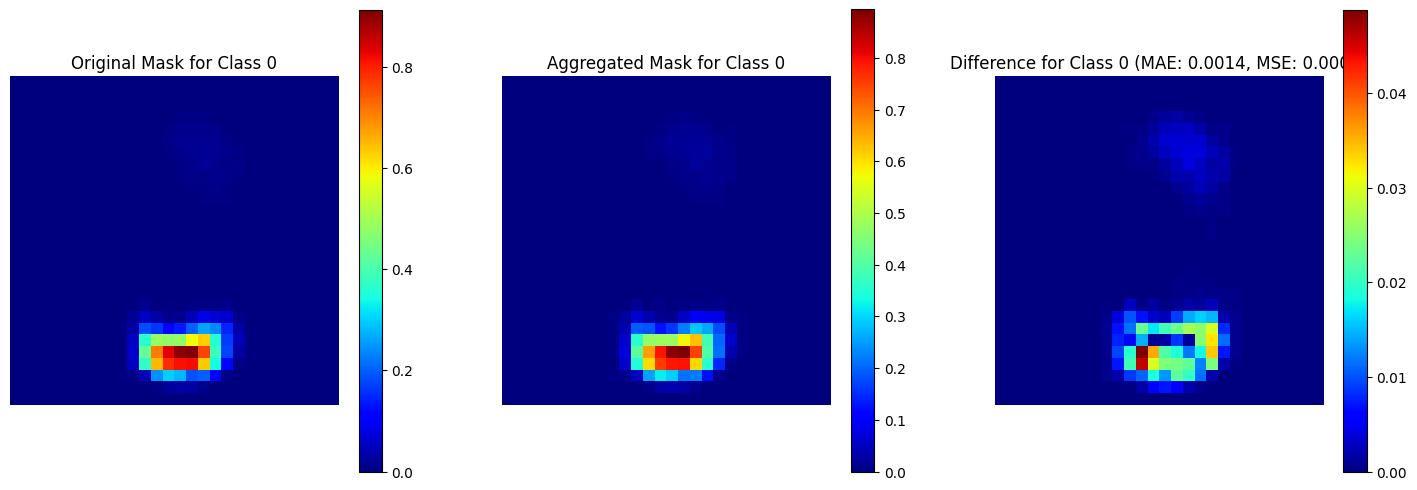

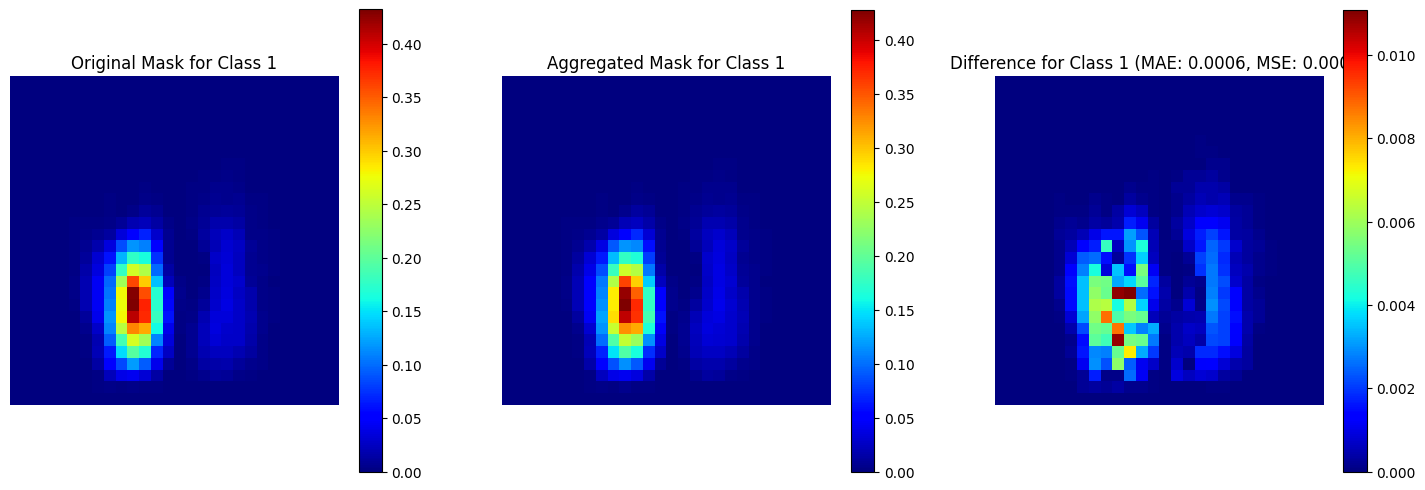

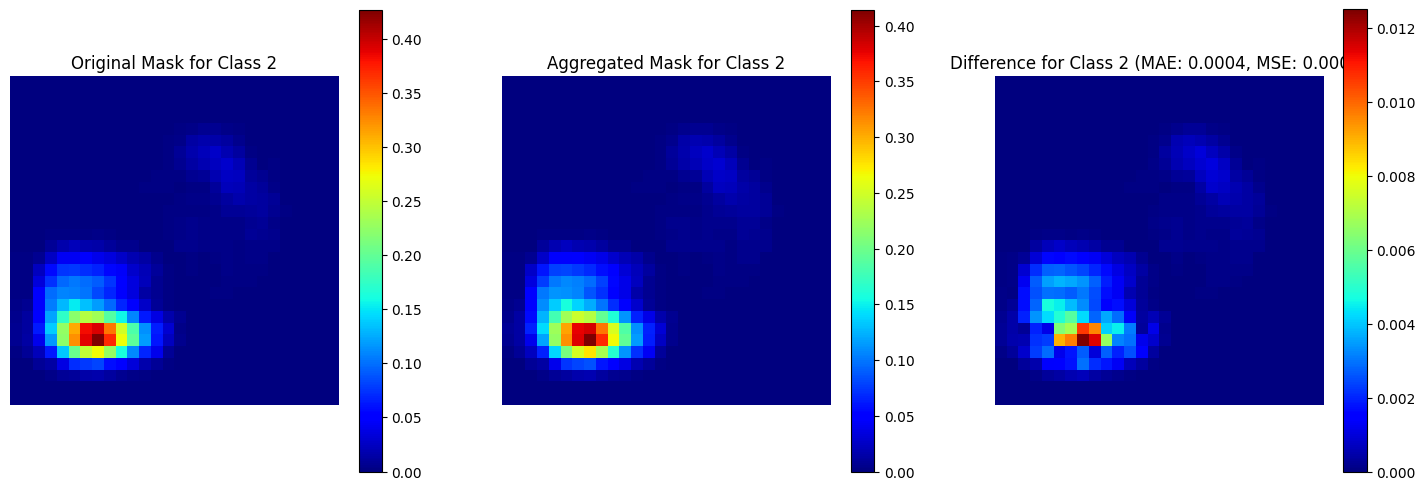

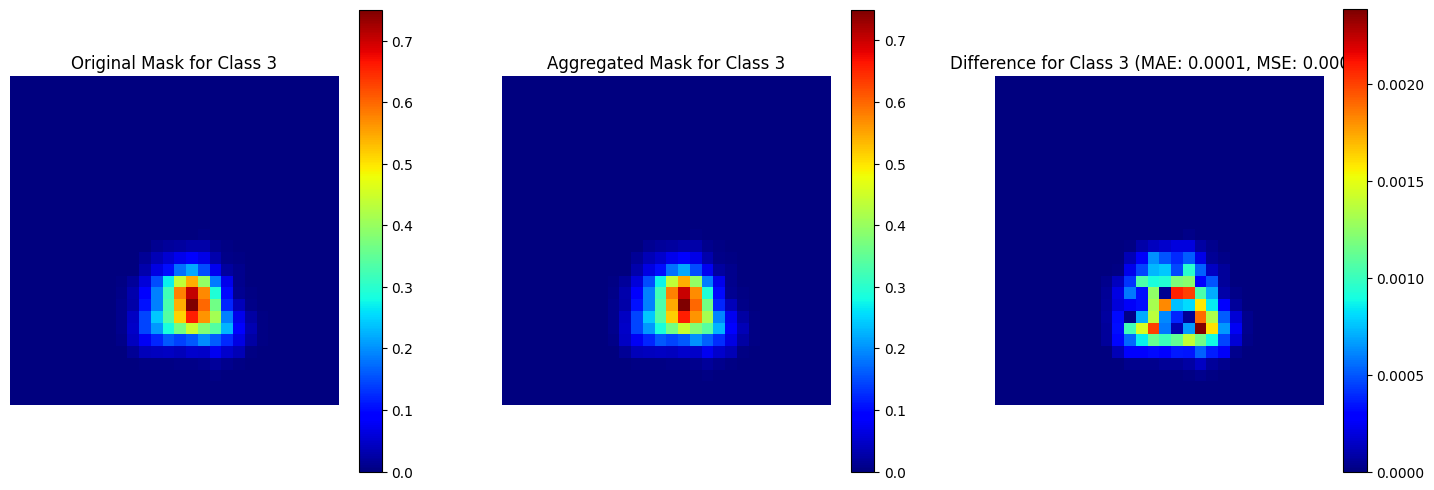

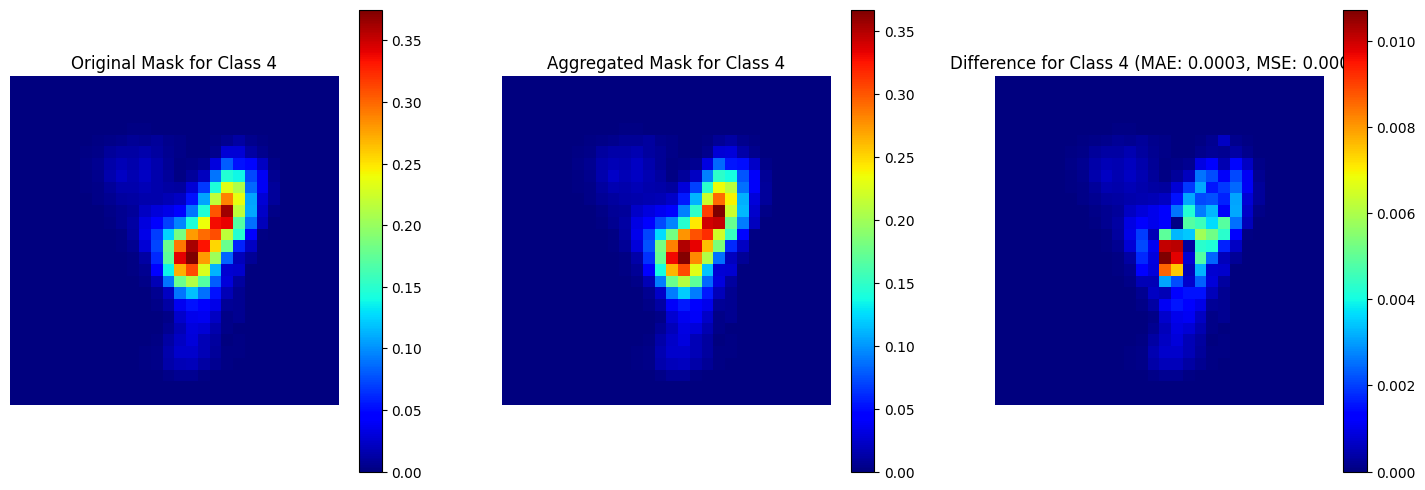

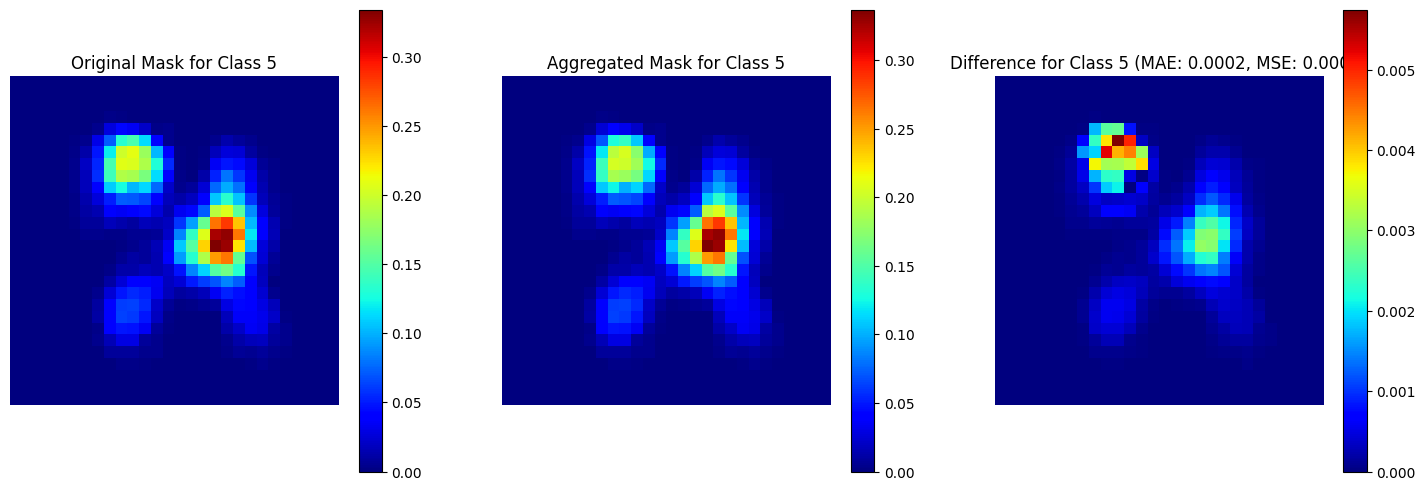

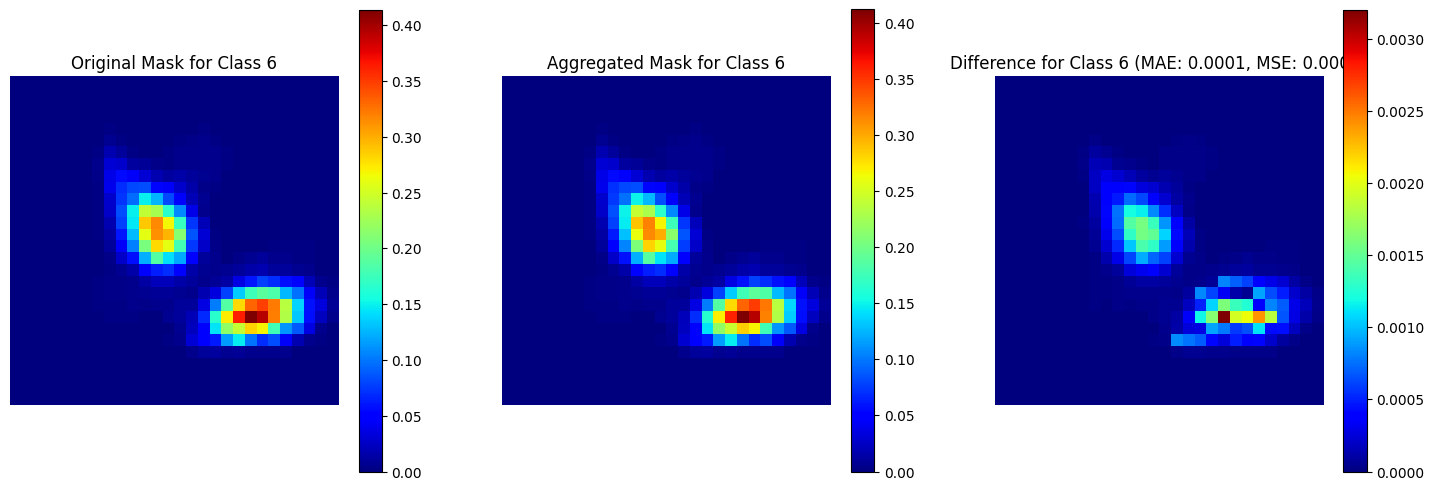

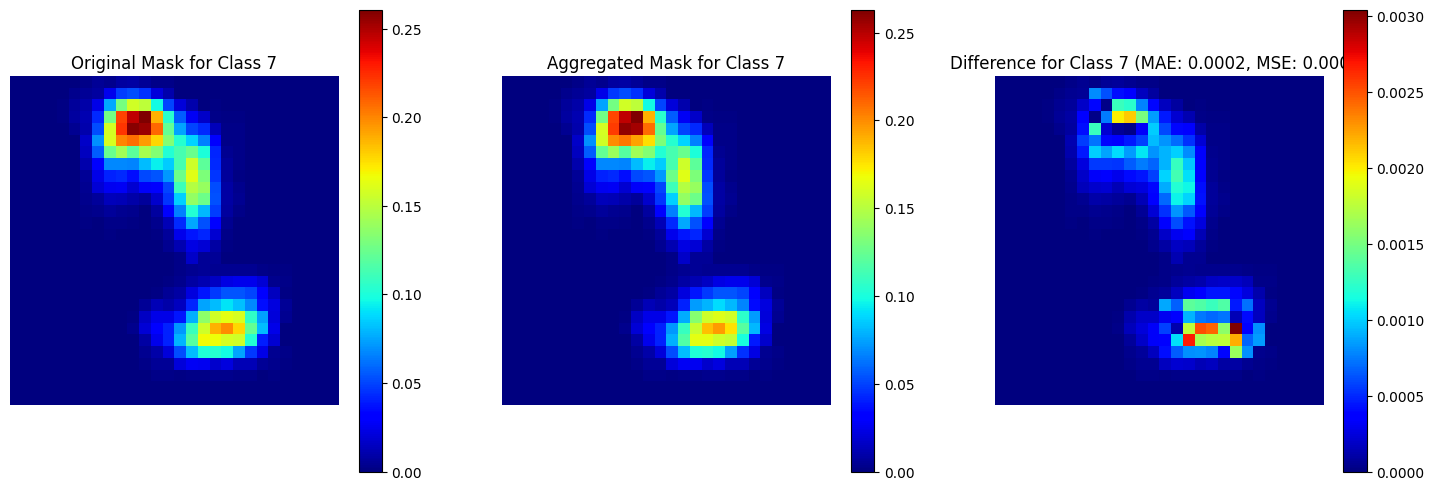

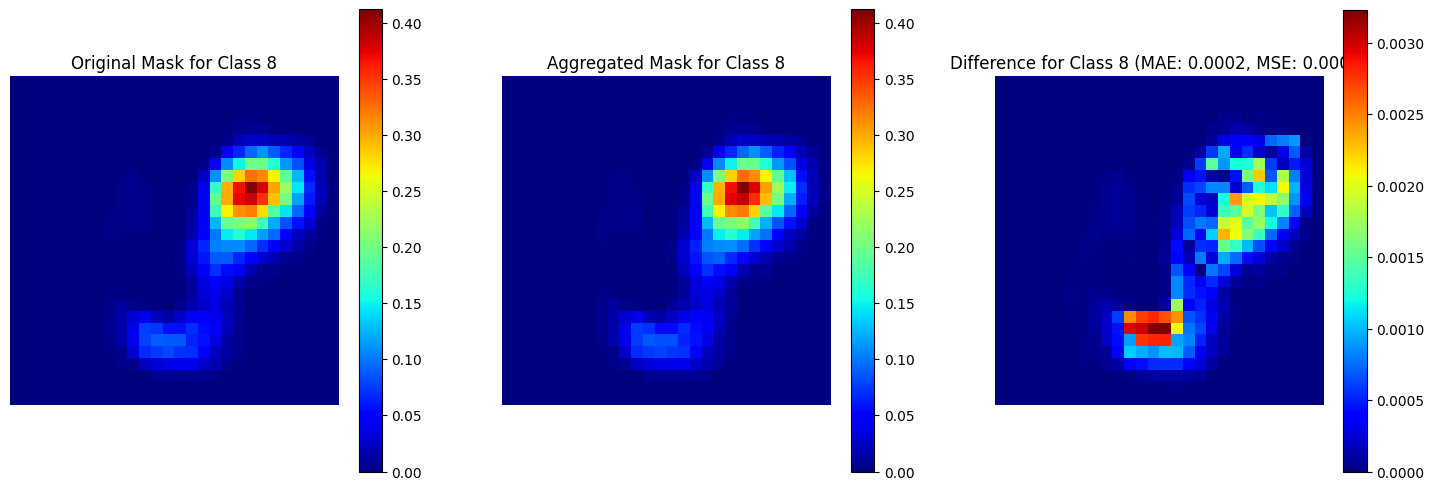

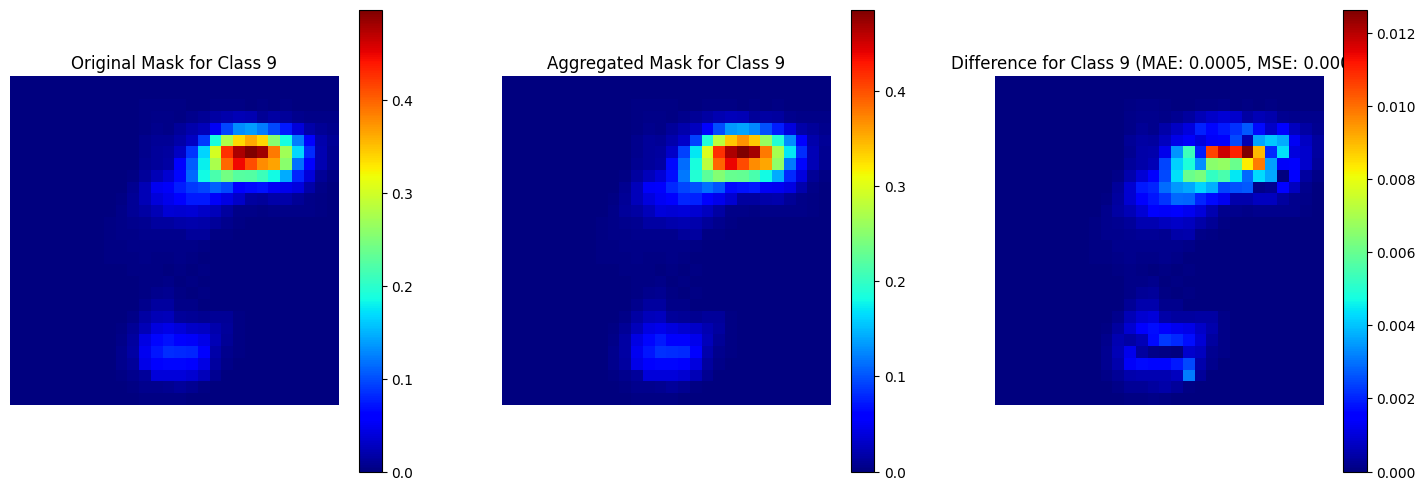

Mean Absolute Error values by class: {0: 0.0013787070006794334, 1: 0.000561499384236453, 2: 0.0004326226604631489, 3: 8.04907310356165e-05, 4: 0.0003486132107163854, 5: 0.00024045619761527194, 6: 0.00010547636139883102, 7: 0.00015549909479920982, 8: 0.00020976839011466652, 9: 0.00047385005404030733}
Mean Squared Error values by class: {0: 2.8354164012428306e-05, 1: 2.256931795087237e-06, 2: 1.781823652573061e-06, 3: 8.656380858127179e-08, 4: 1.357711370632692e-06, 5: 5.081557876923106e-07, 6: 1.0778046730421701e-07, 7: 1.616189058219541e-07, 8: 3.0759158248177216e-07, 9: 2.036713732393379e-06}


In [42]:
def plot_difference(class_id, original_mask, aggregated_mask):
    plt.figure(figsize=(18, 6))
    
    # Calculate MAE and MSE
    mae = np.mean(np.abs(original_mask - aggregated_mask))
    mse = np.mean((original_mask - aggregated_mask)**2)
    
    # Original mask
    plt.subplot(1, 3, 1)
    plt.imshow(original_mask, cmap='jet')
    plt.title(f'Original Mask for Class {class_id}')
    plt.axis('off')
    plt.colorbar()
    
    # Aggregated mask
    plt.subplot(1, 3, 2)
    plt.imshow(aggregated_mask, cmap='jet')
    plt.title(f'Aggregated Mask for Class {class_id}')
    plt.axis('off')
    plt.colorbar()
    
    # Difference
    difference_mask = np.abs(original_mask - aggregated_mask)
    plt.subplot(1, 3, 3)
    plt.imshow(difference_mask, cmap='jet')
    plt.title(f'Difference for Class {class_id} (MAE: {mae:.4f}, MSE: {mse:.4f})')
    plt.axis('off')
    plt.colorbar()
    
    plt.show()
    return mae, mse

# For storing MAE and MSE values
mae_values = {}
mse_values = {}

# Assuming class_top_features and aggregated_superpixels are dictionaries indexed by class ID
for class_id in class_top_features.keys():
    # Average mask before aggregation
    original_masks = [mask for mask, _, _, _ in class_top_features[class_id]]
    avg_original_mask = np.mean(original_masks, axis=0)
    
    # Average mask after aggregation
    aggregated_masks = [mask for mask, _, _, _ in aggregated_superpixels[class_id]]
    avg_aggregated_mask = np.mean(aggregated_masks, axis=0)
    
    # Plotting the masks and their difference
    mae, mse = plot_difference(class_id, avg_original_mask, avg_aggregated_mask)
    
    mae_values[class_id] = mae
    mse_values[class_id] = mse

print("Mean Absolute Error values by class:", mae_values)
print("Mean Squared Error values by class:", mse_values)
